#SARIMA forecasting model

In [3]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
weather_data = pd.read_csv('Weather Data.csv')
weather_data

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres)
0,71075,2010,1,1,NaN,NaN,NaN
1,71075,2010,1,2,NaN,NaN,NaN
2,71075,2010,1,3,NaN,NaN,NaN
3,71075,2010,1,4,NaN,NaN,NaN
4,71075,2010,1,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...
39808,72161,2025,7,24,3.0,-2.7,4.2
39809,72161,2025,7,25,6.0,-2.4,0.2
39810,72161,2025,7,26,2.7,0.0,10.2
39811,72161,2025,7,27,2.5,1.3,15.6


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/opt/anaconda3/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/opt/anaconda3/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/opt/anaconda3/lib/python3.1

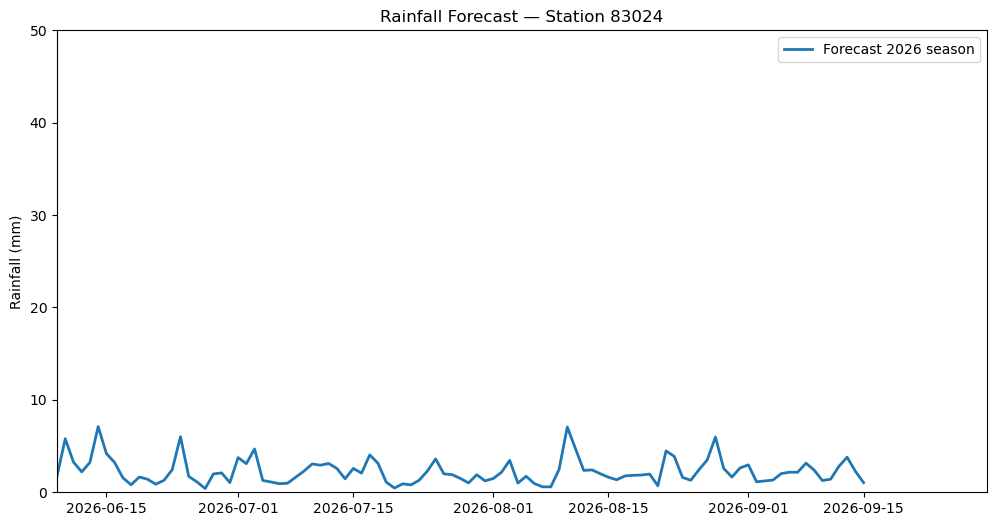

In [5]:
#SARIMA forecast model of finalised favourable resort - Mt Buller
for i in [71032, 83024, 83084, 85291]:
    if i == 83024:
        weather_data = pd.read_csv('Weather Data.csv')
        #Filtering the dates from june to september of each year after 2014
        #Creating datetime index for the weather data
        weather_data = weather_data[(weather_data['Year'] >= 2014)]
        weather_data['date_string'] = weather_data['Year'].astype(str) + '-' + \
                        weather_data['Month'].astype(str).str.zfill(2) + '-' + \
                        weather_data['Day'].astype(str).str.zfill(2)
        weather_data['datetime_column'] = pd.to_datetime(weather_data['date_string'], format='%Y-%m-%d')
        weather_data = weather_data.set_index(pd.to_datetime(weather_data['datetime_column']))
        filtered_weather_data_skiseason = weather_data[(weather_data['Month'] >= 6) & (weather_data['Month'] <= 9)]

        #Filtering dates to match ski seasons
        mask = (filtered_weather_data_skiseason["Month"] == 9) & (filtered_weather_data_skiseason["Day"] > 15)
        ski_season_weather = filtered_weather_data_skiseason.drop(filtered_weather_data_skiseason[mask].index)
        mask2 = (ski_season_weather["Month"] == 6) & (ski_season_weather["Day"] < 9)
        ski_season_weather_final = ski_season_weather.drop(ski_season_weather[mask2].index)
        ski_season_weather_final = ski_season_weather_final.drop(columns=['date_string', 'Month', 'Day', 'datetime_column'])

        #Imputing missing values by finding average natural snowfall from 2014-2017 
        #using averages recorded for all resorts in snow depth historic data
        fill_values = {
        2014: ((107.0+15.0+70.0+26.0+61.0+104.0)/6) * 10,
        2015: ((31.0+9.0+56.0+33.0+29.0+56.0)/6) * 10,
        2016: ((32.0+78.0+69.0+4.0+39.0+6.0)/6) * 10,
        2017: ((12.5+23.2+20.1+72.6+101.0+99.8)/6) * 10
        }

        ski_season_weather_final['Rainfall amount (millimetres)'] = (
            ski_season_weather_final.apply(
                lambda row: fill_values.get(row['Year'], row['Rainfall amount (millimetres)'])
                if pd.isna(row['Rainfall amount (millimetres)']) else row['Rainfall amount (millimetres)'],
                axis=1
            )
        )

        #Forward filling remaining missing values for rainfall, and max/min temp 
        ski_season_weather_final["Rainfall amount (millimetres)"] = ski_season_weather_final["Rainfall amount (millimetres)"].ffill()
        ski_season_weather_final["Maximum temperature (Degree C)"] = ski_season_weather_final["Maximum temperature (Degree C)"].ffill()
        ski_season_weather_final["Minimum temperature (Degree C)"] = ski_season_weather_final["Minimum temperature (Degree C)"].ffill()
        ski_season_weather_final = ski_season_weather_final[(ski_season_weather_final['Bureau of Meteorology station number'] == i)]
        lo, hi = ski_season_weather_final['Rainfall amount (millimetres)'].quantile([0.01, 0.99])
        y_tr = np.log1p(ski_season_weather_final['Rainfall amount (millimetres)'].clip(lo, hi)).interpolate().ffill().bfill()
        
        res = SARIMAX(y_tr, order=(1,1,1), seasonal_order=(1,1,1,99),
                      enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)                     
        rem_2025 = max((pd.Timestamp('2025-09-15') - pd.Timestamp('2025-07-28')).days, 0)
        h = (pd.Timestamp('2026-09-15') - pd.Timestamp('2025-07-28')).days                      
    
        fc_tr = res.get_forecast(steps=h)
        fc_mean = np.expm1(fc_tr.predicted_mean).clip(lower=0)
        
        future_idx = pd.date_range(pd.Timestamp('2025-07-28') + pd.offsets.Day(1), periods=h, freq='D')
        fc_mean.index = future_idx
        fc_2026 = fc_mean.loc['2026-06-09':'2026-09-15']
        fig, ax = plt.subplots(figsize=(12,6))
        ax.plot(fc_2026.index, fc_2026.values, label='Forecast 2026 season', lw=2, linestyle='-')
        ax.axvline(pd.Timestamp('2026-06-09'), color='k', ls='--', alpha=0.5)
        
        ax.set_title(f'Rainfall Forecast — Station {i}')
        ax.set_ylabel('Rainfall (mm)')
        ax.legend()
        ax.set_xlim(pd.Timestamp('2026-06-09'), pd.Timestamp('2026-09-30'))
        ax.set_ylim(0, 50)
        plt.show()

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


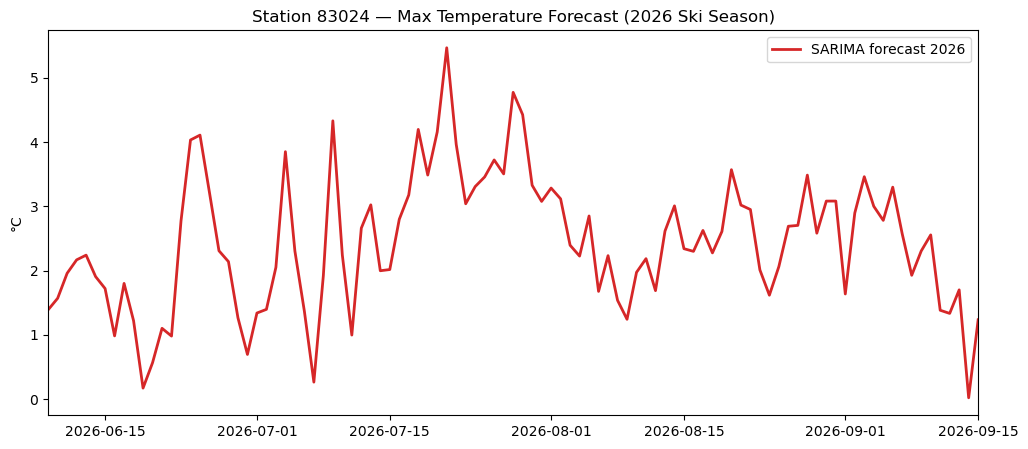

In [6]:
#A function which visualises a SARIMA forecasting model of maximum temperatures for ski season 2026

DATE    = 'datetime_column'
STATION = 'Bureau of Meteorology station number'
TARGET  = 'Maximum temperature (Degree C)'  
SEASON_LEN = 99                               

def forecast_tmax_2026(df, station_id,
                       start_2026='2026-06-09', end_2026='2026-09-15'):

    y = ski_season_weather_final['Maximum temperature (Degree C)'].astype(float).asfreq('D')                 
    lo, hi = y.quantile([0.01, 0.99])                       
    y_tr = y.clip(lo, hi)

    res = SARIMAX(y_tr,
                  order=(1,0,1),
                  seasonal_order=(1,1,1,SEASON_LEN),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit(disp=False)

    last_obs = y_tr.dropna().index.max().normalize()
    end_2026 = pd.Timestamp(end_2026)
    h = (end_2026 - last_obs).days                        

    fc = res.get_forecast(steps=h)
    fc_mean = fc.predicted_mean                           

    future_idx = pd.date_range(last_obs + pd.Timedelta(days=1), periods=h, freq='D')
    fc_mean.index = future_idx

    fc_2026  = fc_mean.loc[start_2026:end_2026]

    fig, ax = plt.subplots(figsize=(12,5))
    #ax.plot(y.index, y.values, label='History Tmax', alpha=0.6)
    ax.plot(fc_2026.index, fc_2026.values, label='SARIMA forecast 2026', lw=2, color='tab:red')
    #ax.fill_between(fc_2026.index, ci_2026.iloc[:,0].values, ci_2026.iloc[:,1].values, alpha=0.2)
    #ax.fill_between(fc_2026.index, alpha=0.2)
    #ax.axvline(last_obs, color='k', ls=':', label='Last observed')
    ax.set_title(f'Station {station_id} — Max Temperature Forecast (2026 Ski Season)')
    ax.set_ylabel('°C'); ax.legend()
    ax.set_xlim(pd.Timestamp('2026-06-09'), pd.Timestamp('2026-09-15'))
    plt.show()

forecast_tmax_2026(ski_season_weather_final, 83024)
